<a href="https://colab.research.google.com/github/he159ok/2001test/blob/master/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE-6524 / CS-6524 Deep Learning
# Assignment 4 [100 pts]

In this assignment, we will explore Recurrent Neural Networks (RNN) to deal with the data with temporal sequence. Specifically, we will generate captions for images. We will design an encoder-decoder architecture to achieve this. This homework is inspired by Stanford CS231n and UCSD CSE253.

## Submission guideline for the coding part (Jupyter Notebook)

1. Click the Save button at the top of the Jupyter Notebook
2. Please make sure to have entered your Virginia Tech PID below
3. Once you've completed everything (make sure output for all cells are visible), select File -> Download as -> PDF via LaTeX
4. Look at the PDF file and make sure all your solutions are displayed correctly there 
7. Zip all the files along with this notebook (Please don't include the data). Name it as Assignment_3_Code_[YOUR PID NUMBER].zip
8. Name your PDF file as Assignment_4_NB_[YOUR PID NUMBER].pdf
9. **<span style="color:blue"> Submit your zipped file and the PDF SEPARATELY**</span>

Note: if facing issues with step 3 refer: https://pypi.org/project/notebook-as-pdf/

## Submission guideline for the coding part (Google Colab)

1. Click the Save button at the top of the Notebook
2. Please make sure to have entered your Virginia Tech PID below
3. Follow last two cells in this notebook for guidelines to download pdf file of this notebook
4. Look at the PDF file and make sure all your solutions are displayed correctly there 
5. Zip all the files along with this notebook (Please don't include the data). Name it as Assignment_2_Code_[YOUR PID NUMBER].zip
6. Name your PDF file as Assignment_4_NB_[YOUR PID NUMBER].pdf
7. **<span style="color:blue"> Submit your zipped file and the PDF SEPARATELY**</span>

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 906199935
### Your Name: Jianfeng He
### Reference (if any): https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3， https://pytorch.org/docs/stable/generated/torch.nn.RNN.html， https://towardsdatascience.com/automatic-image-captioning-with-cnn-rnn-aae3cd442d83


In this homework, you would need to use **Python 3.6+** along with the following packages (**need to update**):
```
1. pytorch 1.2
2. torchvision
3. numpy
4. matplotlib
5. nltk
```
To install pytorch, please follow the instructions on the [Official website](https://pytorch.org/). In addition, the [official document](https://pytorch.org/docs/stable/) could be very helpful when you want to find certain functionalities. 


In [1]:
# import necessary packages and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os

# Image Captioning Using Encoder-Decoder Architecture

Simply, the encoder will take the image as input and encode it into a vector of feature values. The decoder will take this output from encoder as hidden state and starts to predict next words at each step. The following figure illustrates this:

<img src="figs/image_captioning_overview.jpg" width="600">
Figure 1. An overview of the encoder-decoder architecture
(image credit: <a href="https://link.springer.com/chapter/10.1007/978-3-030-04780-1_23">Deep Neural Network Based Image Captioning</a>)

You will use a pre-trained CNN as the encoder and Vanilla RNN/LSTM as decoder to predict the captions.

# Section 1.1 Data
Download dataset following the instructions. We are gonna use Flickr30k dataset, which consists of 31783 images and 158,915 captions. However, instead of using the whole dataset and "results.csv", we will follow Karpathy's Flickr30k annotations and use "dataset_flickr30k.json". Please move "dataset_flickr30k.json" to "flickr30k_images" folder.

## How to download the data (ARC)
Since the original Flickr30K dataset requires application, we will use the dataset from Kaggle. 

Step 1: Register a Kaggle account. https://www.kaggle.com/

Step 2: Log into ARC server in the terminal, e.g. Huckleberry.

Step 3: Install required packages.

    - if you're gonna use powerai on Huckleberry
        # step 1: request for GPU nodes
        salloc --partition=normal_q --nodes=1 --tasks-per-node=10 --gres=gpu:1 bash
        # or if you don't want a GPU, it will be faster to get a job
        salloc --partition=normal_q --nodes=1 --tasks-per-node=10 bash
        # step 2: load all necessary modules
        module load gcc cuda Anaconda3 jdk
        # step 3: activate the virtual environment
        source activate powerai16_ibm
        # step 4: for new packages(take tqdm for example)
        pip install --user kaggle nltk # on hulogin1/hulogin2
        
    - if you're gonna use your own conda environment, simply type
        pip install kaggle nltk
Step 4: Make sure you have kaggle. Type `kaggle`.

Step 5: Download your kaggle.json file from  https://www.kaggle.com/Your_Username/account. In API section, click Create New API Token. Then move you kaggle.json file to the path `/home/your_name_space/.kaggle/kaggle.json`.

Step 6: Download the dataset. Type `kaggle datasets download hsankesara/flickr-image-dataset`.

Step 7: Unzip the dataset. Type `unzip flickr-image-dataset.zip -x "flickr30k_images/flickr30k_images/flickr30k_images/*.jpg" -d "/path-to-Assignment_4/Assignment_4/"`

Step 8: You should have your dataset in `/path-to-Assignment_4/Assignment_4/flickr30k_images/`

Step 9: Move "dataset_flickr30k.json" to "flickr30k_images" folder.

**Note** that you might want to use `nltk.download('punkt')` and `torchvision.models.resnet50(pretrained=True)` before you enter the GPU node.

## How to download the data (Google Colab)
Step 1: Register a Kaggle account.  https://www.kaggle.com/

Step 2: Download your kaggle.json file from  https://www.kaggle.com/Your_Username/account. In API section, click Create New API Token.

Step 3: As we did before, upload all files on Google Drive and open Google Colab.

Step 4: Install required packages.
    
    ! pip install -q kaggle nltk

Step 5: Insert a cell.
    
    
    from google.colab import files
    files.upload()
    
    
    Upload `kaggle.json` you just downloaded.
    
Step 6: Move `kaggle.json` to the right place,
    
    
     ! mkdir ~/.kaggle
     ! cp kaggle.json ~/.kaggle/
    

Step 7: Change the permission.
    
    ! chmod 600 ~/.kaggle/kaggle.json

Step 8: Download.
    
    !kaggle datasets download hsankesara/flickr-image-dataset

Step 9: Move it to your drive and unzip it.
    
    unzip flickr-image-dataset.zip -x "flickr30k_images/flickr30k_images/flickr30k_images/*.jpg" -d "/path-to-Assignment_4/Assignment_4/"
    
Step 10: Move "dataset_flickr30k.json" to "flickr30k_images" folder.

In [ ]:
# !pip install keras

In [ ]:
# ! pip install -q kaggle nltk

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download hsankesara/flickr-image-dataset

In [ ]:
# ! pwd

In [ ]:
# ! ls -al

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ! ls drive/My\ Drive/

In [ ]:
# ! unzip flickr-image-dataset.zip -x "/flickr30k_images/flickr30k_images/flickr30k_images/*.jpg" -d "/content/drive/My Drive/DL_Fall_2020/Assignment_4"

### Colab Setup: 
- Below are some basic steps for colab setup. 
- Make changes based on requirements.
- Comment out in case of ARC or your local device with powerful GPU.

**Note: For Google Colab give proper paths in this notebook and in dataloader.py if required.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
# modify "customized_path_to_homework", path of folder in drive, where you uploaded your homework
path_to_homework = "/content/drive/My Drive/DL_Fall_2020/Assignment_4/"
sys.path.append(path_to_homework)

In [4]:
from dataloader import Flickr30k, get_loader
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch
import torchvision
import matplotlib.pyplot as plt

# Section 1.2 Take a look at the data

In [5]:
# visualize images and captions
flickr = Flickr30k(split='val', root=path_to_homework+'flickr30k_images/')  # load validation set as an example
flickr()

-------flickr30k--------
image root: /content/drive/My Drive/DL_Fall_2020/Assignment_4/flickr30k_images/flickr30k_images
dataset split: val
the length of the dataset: 1014


['People on ATVs and dirt bikes are traveling along a worn path in a field surrounded by trees.', 'Three people on two dirt-bikes and one four-wheeler are riding through brown grass.', 'Three people ride off-road bikes through a field surrounded by trees.', 'Three people on motorbikes follow a trail through dry grass.', "Three people are riding around on ATV's and motorcycles."]


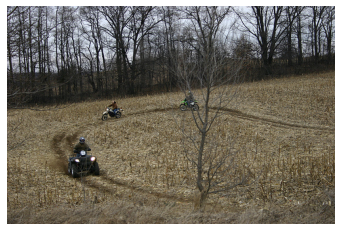

In [8]:
# show a random image and its captions
img_id = np.random.randint(len(flickr))
img = flickr.get_img(img_id)
captions = flickr.get_captions(img_id)

plt.figure()
plt.imshow(img)
plt.axis('off')

print(captions)

In [8]:
del flickr

# Section 1.3 Build vocabulary
We need to build a vocabulary for our dataset. The vocabulary stores all the words and their indices. We will use it to embed and recover the words.

In [10]:
import nltk
import pickle
import json
from tqdm import tqdm
from collections import Counter
nltk.download('punkt') # You can comment this line once you've downloaded 'punkt'

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<start>': 2, '<end>': 3}  # follow Pytorch padding rules: pad sentence with zero.
        self.idx = 4
        self.idx2word = {v: k for k, v in self.word2idx.items()}

    def __call__(self, key):
        if key not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[key]

    def __len__(self):
        return len(self.word2idx)

    def add_word(self, word):
        """
        Add new words
        :param word: word
        """
        if word not in self.word2idx:
            self.word2idx[word] = self.idx  # add a new word
            self.idx2word[self.idx] = word
            self.idx += 1

    def reverse(self, value):
        """
        From idx to words.
        :param value: index
        :return:
        """
        if value not in self.idx2word:
            return self.idx2word[1]  # return '<unk>' if the word is unseen before.
        return self.idx2word[value]

def build_vocab(json_file=path_to_homework+ '/flickr30k_images/dataset_flickr30k.json', threshold=3):
    with open(json_file) as f:
            data = json.load(f)
    f.close()
    counter = Counter()
    for img_idx in tqdm(range(len(data['images']))):
        img_annos = data['images'][img_idx]
        for sent_idx in range(len(img_annos['sentids'])):
#             tokens = img_annos['sentences'][sent_idx]['tokens']  # directly load tokens

            caption = img_annos['sentences'][sent_idx]['raw']
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            
            counter.update(tokens)

    # If the number of words is less than threshold we don't count it.
    words = [word for word, cnt in counter.items() if cnt >= threshold]


    # create a Vocabulary class
    vocab = Vocabulary()

    # add words to Vocab
    for i, word in enumerate(words):
        vocab.add_word(word)

    return vocab

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# let's create a vocabulary for future usage
vocab_path = path_to_homework + '/flickr30k_images/vocab.pkl'
if not os.path.isfile(vocab_path):  # if we don't have vocab, create one
    vocab = build_vocab(json_file=path_to_homework + '/flickr30k_images/dataset_flickr30k.json', threshold=3)
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))
else:  # if we have, load the existing vocab
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    print('vocab loaded!')
    print('the size of vocab:', len(vocab))
f.close()

vocab loaded!
the size of vocab: 9991


In [12]:
vocab_path = path_to_homework + '/flickr30k_images/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print('vocab loaded!')
print('the size of vocab:', len(vocab))
# print(vocab.word2idx.keys())
# print(vocab.idx2word)

# check some random words
for i in range(3):
    random_idx = np.random.randint(len(vocab))
    print('word: {}, index: {}'.format(list(vocab.word2idx.keys())[random_idx], vocab(list(vocab.word2idx.keys())[random_idx])))

vocab loaded!
the size of vocab: 9991
word: navigate, index: 3807
word: knees, index: 3026
word: presents, index: 4596


# Section 2 Vanilla RNN [45 pts]
# Section 2.1 Design the Network: Encoder [5 pts]
Implement the baseline model by using pre-trained ResNet-50 as the encoder and Vanilla RNN as the decoder. Note that we will remove the last layer (fc layer) of ResNet-50 and add a trainable linear layer to finetune it for our task. During the training, we will **freeze** the layer before the fc layer. The encoder should output a feature vector of a fixed size for each image.

In [13]:
class Encoder(nn.Module):
    def __init__(self, emb_dim):
        """
        Use ResNet-50 as encoder.
        :param emb_dim: output size of ResNet-50.
        """
        super(Encoder, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        ###########Your code###############
        # freeze the parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        # replace the last layer (fc layer) with a trainable layer for finetuning
        fc_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(fc_features, emb_dim)

    def forward(self, x):
        x = self.resnet(x)  # output shape: [N, emb_dim]
        return x

# Section 2.2 Design the Network: Decoder [10 pts]
During decoding, we will train a RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) to learn the structure of the caption text throught "**Teacher Forcing**". Teacher forcing works by using the teaching signal from the training dataset at the current time step, $target(t)$, as input in the next time step $x(t+1) = target(t)$, rather than the output $y(t)$ generated by the network. 

As shown in Figure 1 above, RNN will take three inputs: the *current feature*, hidden state ($h_0$) and cell state ($c_0$). The *current feature* for the first step should be the output of encoder to predict '\<start\>' word. Hidden states for this step should be set to None. Then in the second step '\<start\>' will be passed into RNN as the input, and so on.

To use '\<start\>' or any subsequent word as current feature, get its index from the vocabulary you created, convert it to one-hot vector and pass it through a linear layer to embed into a feature (or you can take advantage of Pytorch’s nn.Embedding which does one-hot encoding + linear layer for you).

For convenience, you might want to 'pad' the captions in a mini-batch to convert them into fixed length. You can use 'pack_padded_sequence' function.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Use RNN as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param num_layers: Number of RNN layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: the probability for dropout.
        """
        super(Decoder, self).__init__()
        self.max_length = 30  # the maximum length of a sentence, in case it's trapped
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.t = 1
        #############Your code############
        # you need to implement a Vanilla RNN for the decoder. Take a look at the official documentation.
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN
        
        # one-hot encoding + linear layer
        self.embed = torch.nn.Embedding(self.vocab_size, emb_dim)
        # vanilla rnn network
        self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=hidden_dim, num_layers=num_layers)
        # output layer
        self.out = nn.Linear(in_features=hidden_dim, out_features=vocab_size)
        # self.softmax = nn.Softmax(dim=1)



        

    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions. Note that you need to pad the input so they have the same length
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. size is (batch_size).
        """
        #############Your Code###################
        # compute the embedding using one-hot technique and linear function
        # captions = captions[:, 0:-1] # This is learned from reference
        cap_emb = self.embed(captions)
        # concatenate the encoded features from encoder and embeddings
        # This should be wrong based on dimensions.
        # print(encode_features.shape)
        # print(cap_emb.shape)
        input = torch.cat((encode_features.unsqueeze(1), cap_emb), 1)
        # batch_size = captions.shape[0]
        # o_hid = torch.zeros(batch_size, self.hidden_dim).cuda()
        # o_cell = torch.zeros(batch_size, self.hidden_dim).cuda()
        # input = torch.cat(o_hid, o_cell, dim = 1)
        # feed into RNN.
        # first time

        input_pack = pack_padded_sequence(input, lengths, batch_first=True)
        

        # outputs = torch.zeros(batch_size, captions.shape[1], self.vocab_size).cuda()

        # for t in range(captions.shape[1]):
        #   if t < self.t:
        #       r_out, r_hid = self.rnn(input, o_hid)
        #       input = torch.cat(encode_features, r_out, dim = 0)
        #   else:
        #       input = torch.cat(encode_features, cap_emb[:, t, :], dim = 0)
        #       r_out, r_hid = self.rnn(input, r_hid)
        #   # input = torch.cat(r_hid, r_out)
        #   out_single = self.out(r_out)
        #   # out_single = self.softmax(out_single)
        #   outputs[:, t, :] = out_single

        # outputs, _ = self.rnn(input)
        o1, _ = self.rnn(input_pack)
        # print('below is o1 shape')
        # print(o1.shape)
        outputs = self.out(o1[0])


  
        return outputs

# Encoder-decoder [10 pts]
Now we need to put our encoder and decoder together. 

In the sample_generate stage, the idea is to “let the network run on its own”, predicting the next word, and then use the network’s prediction to obtain the next input word. There are at least two ways to obtain the next word.

- **Deterministic**: Take the maximum output at each step.
- **Stochastic**: Sample from the probability distribution. To get the distribution, we need to compute the weighted softmax of the outputs: $y^i = \exp(o^j/\tau) / \sum_n \exp(o^n/\tau)$, where $o^j$ is the output from the last layer, $n$ is the size of the vocabulary, and $\tau$ is the so-called "temperature". By doing this, you should get a different caption each time.

In [ ]:
class Vanilla_rnn(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Encoder-decoder vanilla RNN.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param num_layers: the number of RNN layers.
        :param dropout: dropout probability
        """
        super(Vanilla_rnn, self).__init__()
        
        #########Your Code################
        # Encoder: ResNet-50
        self.V_enc = Encoder(emb_dim)
        # Decoder: RNN
        self.V_dec = Decoder(vocab_size, emb_dim, hidden_dim, num_layers, dropout)
        self.max_length = self.V_dec.max_length
        self.temp = 1 # temparature for softmax
        self.softmax = nn.Softmax(dim=1)



        

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
        ##########Your code###################
        # forward passing
        x = self.V_enc(x)
        x = self.V_dec(x, captions, lengths)

        return x

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples during the evaluation.
        
        :param x: input image
        :param states: rnn states
        :param mode: which mode we use.  
         - 'Deterministic': Take the maximum output at each step.
         - 'Stochastic': Sample from the probability distribution from the output layer.
        :param temperature: will be used in the stochastic mode
        :return: sample_idxs. Word indices. We can use vocab to recover the sentence later.
        """
        sample_idxs = []  # record the index of your generated words
        
        #################Your Code##################
        # compute the encoded features
        x = self.V_enc.forward(x)
        x = x.unsqueeze(1)
        batch_size = x.shape[0]
        
        for i in range(self.max_length):
          cell, states = self.V_dec.rnn(x, states)
          cell = cell.squeeze(1)
          outputs = self.V_dec.out(cell)
          outputs = self.softmax(outputs/temperature)
        # sample_idxs = torch.zeros(batch_size, self.max_length).cuda()
        # decide which mode we use
          if mode == 'Deterministic':
              # take the maximum index after the softmax
              max_val, chosen = outputs.max(1)
              sample_idxs.append(chosen)

          
              
          elif mode == 'Stochastic':
              # sample from the probability distribution after the softmax
              # Hint: use torch.multinomial() to sample from a distribution.
              chosen = torch.multinomial(outputs, 1)
              sample_idxs.append(chosen)

          # print(sample_idxs)
          x = self.V_dec.embed(chosen)
          x = x.unsqueeze(1)
        sample_idxs = torch.stack(sample_idxs, 1)
        sample_idxs = sample_idxs.squeeze()
        # print(sample_idxs.shape)
        return sample_idxs

# Section 2.3 Training [10 pts]
Train your encoder-decoder. You might also want to check the output sentence every epoch.

In [ ]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 1024
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/rnn/'
os.makedirs(output_dir, exist_ok=True)

## device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Validation code here. We are gonna use this during the training. 
def val(model, data_loader, vocab):
    """
    Inputs:
    :param model: the encoder-decoder network.
    :param data_loader: validation data loader
    :param vocab: pre-built vocabulary
    Output:
    the mean value of validation losses
    """
    print('Validating...')
    val_loss = []
    total_step = len(data_loader)
    criterion = nn.CrossEntropyLoss()
    for itr, (images, captions, lengths) in enumerate(data_loader):
        #######Your Code#########
        # forward inputs and compute the validation loss
        # teacher machanism
        # captions_target = captions[:, 1:].cuda()
        # captions_teacher = captions[:, 0:captions.shape[1]-1].cuda()
        captions = captions.cuda()

        pred_cap = model(images.cuda(), captions, lengths)

        len_tensor = torch.LongTensor(lengths)
        # pred_cap_pack = nn.utils.rnn.pad_packed_sequence(captions, len_tensor)
        pred_cap_pack = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # print(pred_cap.shape)
        # print(captions_target.shape)
        pred_cap = pred_cap.view(-1, len(vocab))
        # captions_target = captions_target.contiguous().view(-1)
        # loss = criterion(pred_cap, captions_target)
        loss = criterion(pred_cap, pred_cap_pack)
        

        # record the validation loss
        val_loss.append(float(loss))
        # Print current loss
        if itr % log_step == 0:
            print('Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(itr, total_step, loss.item(), np.exp(loss.item())))
    val_loss = np.array(val_loss)
    
    # (optional) you might also want to print out the sentence to see the qualitative performance of your model. 
    # You can use deterministic mode to generate sentences
    

    return np.mean(val_loss)


In [ ]:
# Training code here


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab, 
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab, 
                               transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=1, dropout=dropout).to(device)  # build a model

vocab_size=len(vocab)

# loss and optimizer
criterion = nn.CrossEntropyLoss()  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
# for epoch in range(3):
    print('Switch to training...')
    model.train()
    model.cuda()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        model.zero_grad()

        # # teacher machanism
        # captions_target = captions[:, 1:].cuda()
        # captions_teacher = captions[:, 0:captions.shape[1]-1].cuda()

        # pred_cap = model(images.cuda(), captions_teacher, lengths)
        # # print(pred_cap.shape)
        # # print(captions_target.shape)
        # pred_cap = pred_cap.view(-1, vocab_size)
        # captions_target = captions_target.contiguous().view(-1)
        # loss = criterion(input = pred_cap, target=captions_target)

        images = Variable(images).cuda()
        captions = Variable(captions).cuda()

        # len_tensor = torch.Tensor(lengths)
        # captions_target = captions.transpose(0,1)
        # captions_target = model.V_dec.embed(captions_target)

        # pred_cap_pack = nn.utils.rnn.pack_padded_sequence(captions_target, len_tensor.cpu().numpy())

        # captions_target = model.V_dec.embed(captions)
        # captions_target = captions.unsqueeze(-1)

        # print(captions_target.shape)
        # print(lengths.shape)
        pred_cap_pack = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        

        # teacher machanism
        pred_cap = model(images, captions, lengths)
        # print(pred_cap.shape)
        # print(captions_target.shape)
        pred_cap = pred_cap.view(-1, vocab_size)

        # print(captions.shape)
        # print(lengths)
        # print(pred_cap.shape)
        # print(pred_cap_pack.shape)


        loss = criterion(input = pred_cap, target=pred_cap_pack)

        # loss = criterion(input = pred_cap, target=captions.cuda().contiguous().view(-1))

        loss.backward()
        optimizer.step()
        # record the training loss
        Train_Losses.append(float(loss))
        
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_rnn.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode
    # Your code
    
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_rnn.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'vanilla_rnn-best.pth'.format(epoch + 1, itr + 1)))

print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...
Epoch [0/50], Step [0/114], Loss: 9.3095, Perplexity: 11042.3700
Epoch [0/50], Step [50/114], Loss: 3.8869, Perplexity: 48.7580
Epoch [0/50], Step [100/114], Loss: 3.7051, Perplexity: 40.6552
Validating...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step [0/127], Loss: 4.1700, Perplexity: 64.7146
Step [50/127], Loss: 3.9029, Perplexity: 49.5482
Step [100/127], Loss: 3.3427, Perplexity: 28.2953
updated best val loss: 3.6533984124191163
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/rnn/
Switch to training...
Epoch [1/50], Step [0/114], Loss: 3.5659, Perplexity: 35.3715
Epoch [1/50], Step [50/114], Loss: 3.5786, Perplexity: 35.8247
Epoch [1/50], Step [100/114], Loss: 3.5970, Perplexity: 36.4894
Validating...
Step [0/127], Loss: 3.0730, Perplexity: 21.6073
Step [50/127], Loss: 3.3253, Perplexity: 27.8068
Step [100/127], Loss: 3.9963, Perplexity: 54.3938
updated best val loss: 3.5840155646556946
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/rnn/
Switch to training...
Epoch [2/50], Step [0/114], Loss: 3.5565, Perplexity: 35.0399
Epoch [2/50], Step [50/114], Loss: 3.4628, Perplexity: 31.9052
Epoch [2/50], Step [100/114], Loss: 3.4494, Perplexity: 31.4825


# Section 2.4 Evaluation [10 pts]

In [15]:
## evaluation code
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

def caption_generator(model, images, vocab, img_ids, captions, mode='Deterministic', temperature=1.0):
    """
    Generate captions.
    :param mode:
    :return:
    """
    sample_idxs = model.sample_generate(images, mode=mode,
                                        temperature=temperature).data.cpu().numpy()  # [N, max_length]
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
    # for sentence in sample_idxs:
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
        captions.append({'caption': sentence_caption})
        # captions.append(sentence_caption)

    return captions

def run_test(model, data_loader, vocab, mode='Deterministic', temperature=1.0):
    """
    Run your model on the test set.
    Inputs:
    :param model: the model you use
    :param data_loader: the data_loader
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    predictions = []
    for itr, (images, captions, lengths) in enumerate(tqdm(data_loader)):
        images = Variable(images).to(device)
        captions = Variable(captions).to(device)
        outputs = model(images, captions, lengths)
        
        img_ids = list(range(itr * data_loader.batch_size, (itr + 1) * data_loader.batch_size))
        predictions = caption_generator(model, images, vocab, img_ids, 
                                        predictions, mode=mode, temperature=temperature)
        
    return predictions

def evaluation(model, vocab, data_path=path_to_homework + '/flickr30k_images/', mode='Deterministic', temperature=1.0,
               split='test'):
    """
    Evaluate the performance of your model on the test set using BLEU scores.
    Inputs:
    :param model: the model you use
    :param weight_path: the directory to the weights of your model
    :param vocab: vocabulary
    :param data_path: the directory to the dataset
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    # data loader
    test_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split=split, vocab=vocab, 
                                  transform=transform, batch_size=8, shuffle=False, num_workers=4)
    
    # run your model on the test set
    print('Run on the test set...')
    preds = run_test(model, test_data_loader, vocab, mode, temperature)
    
    # load the groundtruth
    gt = test_data_loader.dataset.annos
    
    # evaluate the performance using BLEU score
    score1 = 0
    score2 = 0
    score3 = 0
    score4 = 0
    
    print('Computing BLEU')
    for itr in tqdm(range(len(gt))):
        candidate = preds[itr]['caption']
        reference = [sent['raw'] for sent in gt[itr]['sentences']]
        score1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoother.method1)
        score2 += sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=smoother.method1)
        score3 += sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=smoother.method1)
        score4 += sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=smoother.method1)
    
    bleu1 = 100 * score1/len(gt)
    bleu2 = 100 * score2/len(gt)
    bleu3 = 100 * score3/len(gt)
    bleu4 = 100 * score4/len(gt)
    
    return bleu1, bleu2, bleu3, bleu4

- Test your outputs in the **Deterministic** way by using BLEU scores. You should at achieve a BLEU 4 of 25.

In [ ]:
## Evaluate your model using BLEU score. Use Deterministic mode.

## Image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate your model using BLEU score. Use Deterministic mode
model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model
model.load_state_dict(torch.load(path_to_homework + '/checkpoints/rnn/vanilla_rnn-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 33/1000 [00:00<00:02, 328.15it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 320.82it/s]

BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


- Try different temperatures (e.g. 0.1, 0.2, 0.5, 1.0, 1.5, 2, etc.) during the generation. Report BLEU scores for at least 3 different temperatures.

In [ ]:
## Use at least 3 different temperatures to generate captions on the test set. Report the BLEU scores.
# Your code here
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=0.5)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=2.0)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=4.0)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

# End of code

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 34/1000 [00:00<00:02, 333.73it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 317.89it/s]


BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 33/1000 [00:00<00:02, 326.85it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 327.73it/s]


BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 31/1000 [00:00<00:03, 308.20it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 316.34it/s]

BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


In [ ]:
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=0.1)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=0.2)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

# bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=4.0)
# print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 34/1000 [00:00<00:02, 332.57it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 325.32it/s]


BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 31/1000 [00:00<00:03, 306.19it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 319.55it/s]

BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


In [ ]:
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=0.01)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=20)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

# bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=4.0)
# print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 32/1000 [00:00<00:03, 313.71it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 322.33it/s]


BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 34/1000 [00:00<00:02, 330.90it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 317.61it/s]

BLEU 1:35.05850456473575, BLEU 2:25.639956092665116, BLEU 3:15.748035621368746, BLEU 4:11.28168400079463


# Section 3 Variations [55 pts]
## Section 3.1 LSTM [35 pts]
## Section 3.1.1 Decoder: LSTM [5 pts]
This time, replace the RNN module with an LSTM module.

In [16]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Use LSTM as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param num_layers: Number of LSTM layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: dropout probability
        """
        super(Decoder, self).__init__()
        #############Your code############
        self.max_length = 30  # the maximum length of a sentence, in case it's trapped
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.t = 1
        #############Your code############
        # you need to implement a Vanilla RNN for the decoder. Take a look at the official documentation.
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN
        
        # one-hot encoding + linear layer
        self.embed = torch.nn.Embedding(self.vocab_size, emb_dim)
        # vanilla rnn network
        self.rnn = torch.nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=num_layers)
        # output layer
        self.out = nn.Linear(in_features=hidden_dim, out_features=vocab_size)


    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions.
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        """
        #############Your Code###################
         # compute the embedding using one-hot technique and linear function
        # captions = captions[:, 0:-1] # This is learned from reference
        cap_emb = self.embed(captions)
        # concatenate the encoded features from encoder and embeddings
        # This should be wrong based on dimensions.
        # print(encode_features.shape)
        # print(cap_emb.shape)
        input = torch.cat((encode_features.unsqueeze(1), cap_emb), 1)
        # batch_size = captions.shape[0]
        # o_hid = torch.zeros(batch_size, self.hidden_dim).cuda()
        # o_cell = torch.zeros(batch_size, self.hidden_dim).cuda()
        # input = torch.cat(o_hid, o_cell, dim = 1)
        # feed into RNN.
        # first time

        input_pack = pack_padded_sequence(input, lengths, batch_first=True)
        

        # outputs = torch.zeros(batch_size, captions.shape[1], self.vocab_size).cuda()

        # for t in range(captions.shape[1]):
        #   if t < self.t:
        #       r_out, r_hid = self.rnn(input, o_hid)
        #       input = torch.cat(encode_features, r_out, dim = 0)
        #   else:
        #       input = torch.cat(encode_features, cap_emb[:, t, :], dim = 0)
        #       r_out, r_hid = self.rnn(input, r_hid)
        #   # input = torch.cat(r_hid, r_out)
        #   out_single = self.out(r_out)
        #   # out_single = self.softmax(out_single)
        #   outputs[:, t, :] = out_single

        # outputs, _ = self.rnn(input)
        o1, _ = self.rnn(input_pack)
        # print('below is o1 shape')
        # print(o1.shape)
        outputs = self.out(o1[0])
        # compute the embedding using one-hot technique and linear function
        
        # concatenate the encoded features from encoder and embeddings
                
        # feed into RNN
        
        # output layer

        return outputs

## Encoder-Decoder [5 pts]

In [17]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Encoder-decoder vanilla RNN.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param num_layers: the number of RNN layers.
        """
        super(LSTM, self).__init__()
        
        #########Your Code################
        # Encoder: ResNet-50
        self.V_enc = Encoder(emb_dim)
        # Decoder: LSTM
        self.V_dec = Decoder(vocab_size, emb_dim, hidden_dim, num_layers, dropout)
        self.max_length = self.V_dec.max_length
        self.temp = 1 # temparature for softmax
        # self.max_length = self.V_dec.max_length
        self.softmax = nn.Softmax(dim=1)
        # Encoder: ResNet-50

        # Decoder: LSTM

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
        ##########Your code###################
        # forward passing
        x = self.V_enc(x)
        x = self.V_dec(x, captions, lengths)
        # print(x.shape)
        # x = self.softmax(x)
        # print(x[0].sum())
        # print(x[1].sum())
        return x

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples during the evaluation.
        
        :param x: input image
        :param states: rnn states
        :param mode: which mode we use.  
         - 'Deterministic': Take the maximum output at each step.
         - 'Stochastic': Sample from the probability distribution from the output layer.
        :param temperature: will be used in the stochastic mode
        :return: sample_idxs. Word indices. We can use vocab to recover the sentence.
        """
        sample_idxs = []
        #################Your Code##################
        # compute the encoded features
        
        # decide which mode we use
        sample_idxs = []  # record the index of your generated words
        
        #################Your Code##################
        # compute the encoded features
        x = self.V_enc.forward(x)
        x = x.unsqueeze(1)
        batch_size = x.shape[0]
        
        for i in range(self.max_length):
          cell, states = self.V_dec.rnn(x, states)
          cell = cell.squeeze(1)
          outputs = self.V_dec.out(cell)
          outputs = self.softmax(outputs/temperature)
        # sample_idxs = torch.zeros(batch_size, self.max_length).cuda()
        # decide which mode we use
          if mode == 'Deterministic':
              # take the maximum index after the softmax
              max_val, chosen = outputs.max(1)
              sample_idxs.append(chosen)

          
              
          elif mode == 'Stochastic':
              # sample from the probability distribution after the softmax
              # Hint: use torch.multinomial() to sample from a distribution.
              chosen = torch.multinomial(outputs, 1)
              sample_idxs.append(chosen)

          # print(sample_idxs)
          x = self.V_dec.embed(chosen)
          x = x.unsqueeze(1)
        sample_idxs = torch.stack(sample_idxs, 1)
        sample_idxs = sample_idxs.squeeze()
        # print(sample_idxs.shape)
        return sample_idxs

## Section 3.1.2 Training [10 pts]
Use the same set of hyper-parameters (hidden units, optimizer, learning rate etc.) for both models.

In [18]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 1024
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/lstm/'
os.makedirs(output_dir, exist_ok=True)

In [27]:
# Training code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

vocab_size=len(vocab)

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    model.cuda()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        model.zero_grad()

        # # teacher machanism
        # captions_target = captions[:, 1:].cuda()
        # captions_teacher = captions[:, 0:captions.shape[1]-1].cuda()

        # pred_cap = model(images.cuda(), captions_teacher, lengths)
        # # print(pred_cap.shape)
        # # print(captions_target.shape)
        # pred_cap = pred_cap.view(-1, vocab_size)
        # captions_target = captions_target.contiguous().view(-1)
        # loss = criterion(input = pred_cap, target=captions_target)

        images = Variable(images).cuda()
        captions = Variable(captions).cuda()

        # len_tensor = torch.Tensor(lengths)
        # captions_target = captions.transpose(0,1)
        # captions_target = model.V_dec.embed(captions_target)

        # pred_cap_pack = nn.utils.rnn.pack_padded_sequence(captions_target, len_tensor.cpu().numpy())

        # captions_target = model.V_dec.embed(captions)
        # captions_target = captions.unsqueeze(-1)

        # print(captions_target.shape)
        # print(lengths.shape)
        pred_cap_pack = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        

        # teacher machanism
        pred_cap = model(images, captions, lengths)
        # print(pred_cap.shape)
        # print(captions_target.shape)
        pred_cap = pred_cap.view(-1, vocab_size)

        # print(captions.shape)
        # print(lengths)
        # print(pred_cap.shape)
        # print(pred_cap_pack.shape)


        loss = criterion(input = pred_cap, target=pred_cap_pack)

        # loss = criterion(input = pred_cap, target=captions.cuda().contiguous().view(-1))

        loss.backward()
        optimizer.step()
        # record the training loss
        Train_Losses.append(float(loss))
        
        # record the training loss
        
        
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_lstm.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode
    # Your code
    
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_lstm.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'lstm-best.pth'.format(epoch + 1, itr + 1)))

print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...
Epoch [0/50], Step [0/114], Loss: 9.2192, Perplexity: 10088.7411
Epoch [0/50], Step [50/114], Loss: 3.4860, Perplexity: 32.6545
Epoch [0/50], Step [100/114], Loss: 3.4551, Perplexity: 31.6629
Validating...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step [0/127], Loss: 3.1429, Perplexity: 23.1704
Step [50/127], Loss: 2.6932, Perplexity: 14.7789
Step [100/127], Loss: 3.2981, Perplexity: 27.0622
updated best val loss: 3.35603788330799
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/lstm/
Switch to training...
Epoch [1/50], Step [0/114], Loss: 3.2054, Perplexity: 24.6665
Epoch [1/50], Step [50/114], Loss: 3.3472, Perplexity: 28.4226
Epoch [1/50], Step [100/114], Loss: 3.1842, Perplexity: 24.1489
Validating...
Step [0/127], Loss: 3.5692, Perplexity: 35.4877
Step [50/127], Loss: 3.0309, Perplexity: 20.7155
Step [100/127], Loss: 3.4983, Perplexity: 33.0600
updated best val loss: 3.2554312503243996
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/lstm/
Switch to training...
Epoch [2/50], Step [0/114], Loss: 3.1950, Perplexity: 24.4094
Epoch [2/50], Step [50/114], Loss: 3.1746, Perplexity: 23.9171
Epoch [2/50], Step [100/114], Loss: 3.1277, Perplexity: 22.8212


## Section 3.1.3 Evalution [10 pts]
Evaluate your model on the test set by perplexity score or BLEU score

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

vocab_size=len(vocab)

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

In [23]:
## Evaluate your model using BLEU score. Use Deterministic mode.
# Your code here
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate your model using BLEU score. Use Deterministic mode
model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model
model.load_state_dict(torch.load(path_to_homework + '/checkpoints/lstm/lstm-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))
# End of code

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 27/1000 [00:00<00:03, 263.66it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 262.22it/s]

BLEU 1:79.52250788590293, BLEU 2:55.61200279892869, BLEU 3:34.690011818310296, BLEU 4:22.871307727235326


In [24]:
## Use at least 3 different temperatures to generate captions on the test set. Report the BLEU scores.
# Your code here
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=0.1)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=0.2)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic', temperature=2.0)
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

# End of code
# End of code

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 26/1000 [00:00<00:03, 254.58it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 264.76it/s]


BLEU 1:79.45829118534051, BLEU 2:55.553824535603255, BLEU 3:34.67496540732476, BLEU 4:22.856047415953743


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 26/1000 [00:00<00:03, 251.61it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 266.65it/s]


BLEU 1:79.51858490751687, BLEU 2:55.60851683391817, BLEU 3:34.71293724144444, BLEU 4:22.889354668147654


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 26/1000 [00:00<00:03, 256.16it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 268.64it/s]

BLEU 1:79.55776289147639, BLEU 2:55.61634804094924, BLEU 3:34.71424875625786, BLEU 4:22.89380332882884


## Section 3.1.4 Discussion [5 pts]
What's the difference between Vanilla RNN and LSTM (training loss, evaluation results, etc)?

**Your comments**:  
1. The training loss and perxility are smaller for LSTM.
2. The evaluation result is better for LSTM, though I believe the parameters for RNN might not be well-designed.
3. The tempature is more effective for the LSTM, because there is a little various change for the BLUE in the LSTM.

## Section 3.2 Using pre-trained word embeddings [20 pts]
For now, the decoder uses a word as input by converting it into a fixed size embedding, and our networks learn these word embeddings by training. In this experiment, you will use pre-trained word embeddings like Word2Vec or GloVe in LSTM. If you use Pytorch’s nn.Embedding layer, you can initialize its weights with a matrix containing pre-trained word embeddings for all words in your vocabulary, and freeze the weights (i.e. don’t train this layer). You can find these embeddings online.

Some resources:
- GloVe: https://nlp.stanford.edu/projects/glove/
- Word2Vec: http://jalammar.github.io/illustrated-word2vec/

In case you don't know how to get one, we've already provided a light GloVe embedding: wm_06.npy, which can produce 300-d word embeddings.

## Section 3.2.1 Encoder-decoder [10 pts]

In [44]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0):
        """
        Use LSTM as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param pretrained_emb: the path to the pretrained embedding
        :param num_layers: Number of LSTM layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: dropout probability
        """
        super(Decoder, self).__init__()
        self.max_length = 30  # in case it's trapped
        ###### Your Code#########
        # load pre-trained embedding weights and freeze this layer
        

        # embedding = nn.Embedding.from_pretrained(torch.fromnumpy(pretrained_weights))

        # self.max_length = 30  # the maximum length of a sentence, in case it's trapped
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.t = 1
        #############Your code############
        # you need to implement a Vanilla RNN for the decoder. Take a look at the official documentation.
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN
        
        # one-hot encoding + linear layer
        
        print(pretrained_emb)
        pretrained_weights = np.load(pretrained_emb)
        self.embed = torch.nn.Embedding(self.vocab_size, emb_dim)
        self.embed.weight.data.copy_(torch.Tensor(pretrained_weights))
        for param in self.embed.parameters():
          param.requires_grad = False

        # vanilla rnn network
        self.rnn = torch.nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=num_layers)
        # output layer
        self.out = nn.Linear(in_features=hidden_dim, out_features=vocab_size)
        # lstm network
        
        
        # output layer
    
    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions.
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        """
        #############Your Code###################
        # compute the embedding using one-hot technique and linear function
        
        # concatenate the encoded features from encoder and embeddings
                
        cap_emb = self.embed(captions)
        # concatenate the encoded features from encoder and embeddings
        # This should be wrong based on dimensions.
        # print(encode_features.shape)
        # print(cap_emb.shape)
        input = torch.cat((encode_features.unsqueeze(1), cap_emb), 1)
        # batch_size = captions.shape[0]
        # o_hid = torch.zeros(batch_size, self.hidden_dim).cuda()
        # o_cell = torch.zeros(batch_size, self.hidden_dim).cuda()
        # input = torch.cat(o_hid, o_cell, dim = 1)
        # feed into RNN.
        # first time

        input_pack = pack_padded_sequence(input, lengths, batch_first=True)
        

        # outputs = torch.zeros(batch_size, captions.shape[1], self.vocab_size).cuda()

        # for t in range(captions.shape[1]):
        #   if t < self.t:
        #       r_out, r_hid = self.rnn(input, o_hid)
        #       input = torch.cat(encode_features, r_out, dim = 0)
        #   else:
        #       input = torch.cat(encode_features, cap_emb[:, t, :], dim = 0)
        #       r_out, r_hid = self.rnn(input, r_hid)
        #   # input = torch.cat(r_hid, r_out)
        #   out_single = self.out(r_out)
        #   # out_single = self.softmax(out_single)
        #   outputs[:, t, :] = out_single

        # outputs, _ = self.rnn(input)
        o1, _ = self.rnn(input_pack)
        # print('below is o1 shape')
        # print(o1.shape)
        outputs = self.out(o1[0])


  
        return outputs

In [45]:
class Word_embeddings(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0):
        """
        Encoder-decoder baseline.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param pretrained_emb: the path to the pretrained embedding
        :param num_layers: the number of LSTM layers.
        :param dropout: dropout probability.
        """
        super(Word_embeddings, self).__init__()
        # self.max_length = self.decoder.max_length
        #########Your Code################

        # Encoder: ResNet-50
        self.V_enc = Encoder(emb_dim)
        # Decoder: LSTM
        self.V_dec = Decoder(vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers, dropout)
        self.max_length = self.V_dec.max_length
        self.temp = 1 # temparature for softmax
        self.max_length = self.V_dec.max_length
        self.softmax = nn.Softmax(dim=1)
        # Encoder: ResNet-50

        # Decoder: LSTM


        

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
        ##########Your code###################
        # forward passing
        x = self.V_enc(x)
        x = self.V_dec(x, captions, lengths)
        # print(x.shape)
        # x = self.softmax(x)
        return x

        return x

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples.
        :param x:
        :return:
        """
        # sample_idxs = []
        #################Your Code##################
        # compute the encoded features
        sample_idxs = []
        #################Your Code##################
        # compute the encoded features
        
        # decide which mode we use
        sample_idxs = []  # record the index of your generated words
        
        #################Your Code##################
        # compute the encoded features
        x = self.V_enc.forward(x)
        x = x.unsqueeze(1)
        batch_size = x.shape[0]
        
        for i in range(self.max_length):
          cell, states = self.V_dec.rnn(x, states)
          cell = cell.squeeze(1)
          outputs = self.V_dec.out(cell)
          outputs = self.softmax(outputs/temperature)
        # sample_idxs = torch.zeros(batch_size, self.max_length).cuda()
        # decide which mode we use
          if mode == 'Deterministic':
              # take the maximum index after the softmax
              max_val, chosen = outputs.max(1)
              sample_idxs.append(chosen)

          
              
          elif mode == 'Stochastic':
              # sample from the probability distribution after the softmax
              # Hint: use torch.multinomial() to sample from a distribution.
              chosen = torch.multinomial(outputs, 1)
              sample_idxs.append(chosen)

          # print(sample_idxs)
          x = self.V_dec.embed(chosen)
          x = x.unsqueeze(1)
        sample_idxs = torch.stack(sample_idxs, 1)
        sample_idxs = sample_idxs.squeeze()
        # print(sample_idxs.shape)
        return sample_idxs
            
            
        # return sample_idxs

## Section 3.2.2 Training [5 pts]

In [48]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 300
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/pretrained_emb/'
os.makedirs(output_dir, exist_ok=True)

In [49]:
# Training code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

# pretrained embedding weights
pre_emb_path = '/content/drive/My Drive/DL_Fall_2020/Assignment_4/wm_06.npy'  # type the path to the pretrained embedding you find

model = Word_embeddings(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, pretrained_emb=pre_emb_path,
                   num_layers=1, dropout=dropout).to(device)  # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
# for epoch in range(2):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        model.zero_grad()

        # # teacher machanism
        # captions_target = captions[:, 1:].cuda()
        # captions_teacher = captions[:, 0:captions.shape[1]-1].cuda()

        # pred_cap = model(images.cuda(), captions_teacher, lengths)
        # # print(pred_cap.shape)
        # # print(captions_target.shape)
        # pred_cap = pred_cap.view(-1, vocab_size)
        # captions_target = captions_target.contiguous().view(-1)
        # loss = criterion(input = pred_cap, target=captions_target)

        images = Variable(images).cuda()
        captions = Variable(captions).cuda()

        # len_tensor = torch.Tensor(lengths)
        # captions_target = captions.transpose(0,1)
        # captions_target = model.V_dec.embed(captions_target)

        # pred_cap_pack = nn.utils.rnn.pack_padded_sequence(captions_target, len_tensor.cpu().numpy())

        # captions_target = model.V_dec.embed(captions)
        # captions_target = captions.unsqueeze(-1)

        # print(captions_target.shape)
        # print(lengths.shape)
        pred_cap_pack = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        

        # teacher machanism
        pred_cap = model(images, captions, lengths)
        # print(pred_cap.shape)
        # print(captions_target.shape)
        pred_cap = pred_cap.view(-1, vocab_size)

        # print(captions.shape)
        # print(lengths)
        # print(pred_cap.shape)
        # print(pred_cap_pack.shape)


        loss = criterion(input = pred_cap, target=pred_cap_pack)

        # loss = criterion(input = pred_cap, target=captions.cuda().contiguous().view(-1))

        loss.backward()
        optimizer.step()
        # record the training loss
        Train_Losses.append(float(loss))
        
        # record the training loss
        
        
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_lstm.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode
    # Your code
    
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_lstm.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'pretrain-best.pth'.format(epoch + 1, itr + 1)))

print('It took: {} s'.format(time.time() - tic))

/content/drive/My Drive/DL_Fall_2020/Assignment_4/wm_06.npy
Start training...
Switch to training...
Epoch [0/50], Step [0/114], Loss: 9.2115, Perplexity: 10011.7861
Epoch [0/50], Step [50/114], Loss: 3.4356, Perplexity: 31.0514
Epoch [0/50], Step [100/114], Loss: 3.3126, Perplexity: 27.4576
Validating...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step [0/127], Loss: 3.3406, Perplexity: 28.2351
Step [50/127], Loss: 3.0281, Perplexity: 20.6574
Step [100/127], Loss: 3.6033, Perplexity: 36.7191
updated best val loss: 3.264486876059705
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/pretrained_emb/
Switch to training...
Epoch [1/50], Step [0/114], Loss: 3.2568, Perplexity: 25.9674
Epoch [1/50], Step [50/114], Loss: 3.1437, Perplexity: 23.1901
Epoch [1/50], Step [100/114], Loss: 3.2195, Perplexity: 25.0145
Validating...
Step [0/127], Loss: 3.5714, Perplexity: 35.5672
Step [50/127], Loss: 3.3306, Perplexity: 27.9546
Step [100/127], Loss: 2.9639, Perplexity: 19.3730
updated best val loss: 3.1376200923769493
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/pretrained_emb/
Switch to training...
Epoch [2/50], Step [0/114], Loss: 3.1068, Perplexity: 22.3492
Epoch [2/50], Step [50/114], Loss: 3.0790, Perplexity: 21.7376
Epoch [2/50], Step [100/114], Loss: 3.0533,

## Section 3.2.3 Evaluation [3 pts]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = Word_embeddings(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

vocab_size=len(vocab)

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

In [51]:
# ## Evaluate your model using BLEU score. Use Deterministic mode
# transform = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         #     transforms.RandomCrop(224, pad_if_needed=True),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                              std=(0.229, 0.224, 0.225))])

# ## Evaluate your model using BLEU score. Use Deterministic mode
# model = Word_embeddings(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, pretrained_emb=pre_emb_path,
#                    num_layers=1, dropout=dropout).to(device)  # build a model
# model.load_state_dict(torch.load(path_to_homework + '/checkpoints/pretrained_emb/pretrain-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  3%|▎         | 27/1000 [00:00<00:03, 268.23it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:03<00:00, 266.92it/s]

BLEU 1:72.5875751546411, BLEU 2:50.07678671454675, BLEU 3:28.335675463421353, BLEU 4:18.027034169323723


## Section 3.2.4 Discussion [2 pts]
Compared to index embeddings, do pretrained embeddings improve the performance? Try to explain it.

**Your Comments**:
The extra presetting wordembdding does not imporve the performance. This might be that, the pretraiend wordembedding is not the well adapted to the following layers in LSTM. However, in the situation training word embedding without freezing the parameters, the weights in word embedding is better adaptive to the LSTM. 

### Guidelines for Downloading PDF in Google Colab
- Run below cells only in Google Colab, Comment out in case of Jupyter notebook

In [52]:
#Run below two lines (in google colab), installation steps to get .pdf of the notebook

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

# After installation, comment above two lines and run again to remove installation comments from the notebook.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [57]:
# Find path to your notebook file in drive and enter in below line

!jupyter nbconvert --to PDF "/content/drive/My Drive/DL_Fall_2020/Assignment_4/Assignment_4.ipynb"

#Example: "/content/drive/My Drive/DL_Fall_2020/Assignment_4/DL_Assignment_4.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/DL_Fall_2020/Assignment_4/Assignment_4.ipynb to PDF
[NbConvertApp] Support files will be in Assignment_4_files/
[NbConvertApp] Making directory ./Assignment_4_files
[NbConvertApp] Writing 304724 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/tcolorbox/tcolorbox.sty
(/usr/share/texlive/texmf